In [474]:
%%time
print('yes')

yes
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 201 µs


In [475]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [471]:
import numpy as np
import torch as t
t.autograd.set_detect_anomaly(True)
import tqdm
from torch.distributions.multivariate_normal import MultivariateNormal
import time

In [465]:
from csmc import *

In [466]:
def potential(x, _lambda, **kwargs):
    """
    """
    
    return ((1. - _lambda)*(x**2) + _lambda * (0.5 * (x-1)**2)).sum()

In [479]:
def numpy_potential(x, _lambda):
    return np.sum((1. - _lambda)*(x**2) + _lambda*(0.5 * (x-1.)**2))

In [476]:
%%time
x = t.tensor([0.], requires_grad=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 438 µs


In [489]:
%%time
x = t.tensor([0.], requires_grad=True)
pot = potential(x, 0.)
pot.backward()

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 7.36 ms


In [490]:
%%time
x = np.array([0.])
pot = numpy_potential(x, 0.)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 123 µs


In [491]:
np.finfo(float).eps

2.220446049250313e-16

In [492]:
%%time
from scipy import optimize
def func(x, c0, c1):
    "Coordinate vector `x` should be an array of size two."
    return c0 * x[0]**2 + c1*x[1]**2
x = np.ones(2)
c0, c1 = (1, 200)
eps = np.sqrt(np.finfo(float).eps)
optimize.approx_fprime(x, func, [eps,eps], c0, c1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 130 µs


array([  2.        , 400.00000381])

In [478]:
%%time
pot.backward()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.89 ms


let's plot the distributions at t=0,1

In [450]:
xs = t.tensor(np.linspace(-8, 8, 1000))
t0s = t.tensor(np.zeros(1000))
t1s = t.tensor(np.ones(1000))
ys_t0 = np.array([(-potential(x, t)).exp() for x, t in zip(xs, t0s)])
ys_t1 = np.array([(-potential(x, t)).exp() for x, t in zip(xs, t1s)])

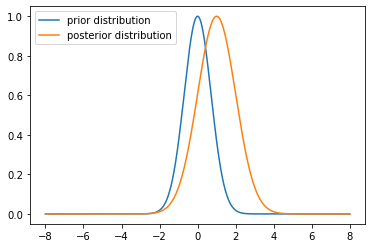

In [451]:
plt.plot(xs, ys_t0, label = f"prior distribution")
plt.plot(xs, ys_t1, label = f"posterior distribution")
plt.legend()

ok, now can we do AIS?


In [341]:
#define an initial position.
from torch.distributions.multivariate_normal import MultivariateNormal
mvn = MultivariateNormal(t.tensor([[0.]]), 0.5 * t.eye(1))

In [342]:
num_particles = 1000
iterations = 10
incremental_works = t.zeros(num_particles, iterations)
positions = t.zeros(num_particles, iterations)
lambda_schedule = t.tensor(np.linspace(0., 1., iterations))
mvn = MultivariateNormal(t.tensor([[0.]]), 0.5 * t.eye(1))
dt=1e-2
import tqdm
for particle_idx in tqdm.trange(num_particles):
    x = mvn.sample()
    x.requires_grad=True
    incremental_work_array, trajectory = AIS(x=x, potential=potential, lambda_schedule=lambda_schedule, propagator=MALA_propagator, dt=dt)
    incremental_works[particle_idx,:] = incremental_work_array
    positions[particle_idx] = t.flatten(trajectory)
    
    
    
    
    






  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: potential() missing 1 required positional argument: '_lambda'

In [ ]:
sns.distplot(positions[:,0])
sns.distplot(positions[:,-1])

In [ ]:
incremental_works

In [ ]:
cum_works = t.cumsum(incremental_works, 1)

In [ ]:
plt.plot(incremental_works[0,:])

In [ ]:
last_cum_works = cum_works[:,-1]
from pymbar import EXP
print(EXP(last_cum_works.numpy()))

In [7]:
sns.distplot(weights)
t.log(t.mean(weights))
plt.xlim(-1, 3)

NameError: name 'weights' is not defined

ok, so it looks like AIS works, more or less...can we make an ULA uncontrolled SMC proposal and assert that the logw returned is the same as a compute_ULA_logw?

In [6]:
x = MultivariateNormal(t.tensor([[0.]]), 0.5 * t.eye(1)).sample()
x.requires_grad=True
x_new, logw = ULA_uncontrolled_SMC(x, potential, t.tensor(0.), t.tensor(1.), dt=1e-2)

In [7]:
logw

tensor([-3.9956])

In [8]:
x_new.requires_grad=True

In [9]:
old_potential_old_x = potential(x, t.tensor(0.))
new_potential_old_x = potential(x, t.tensor(1.))

new_potential_new_x = potential(x_new, t.tensor(1.))
new_potential_old_x.backward()
new_potential_new_x.backward()

In [10]:
compute_ULA_logw(log_gamma_old = -old_potential_old_x, 
                 log_gamma_new = -new_potential_new_x, 
                 x_old = x, 
                 x_new = x_new, 
                 grad_log_gamma_x_new = -x_new.grad, 
                 grad_log_gamma_x_old = -x.grad, 
                 dt = 1e-2)

tensor(-3.9956)

great, so we are recovering the correct log weight in the uncontrolled regime

at this moment, i have to talk about the form of the controlled twisted initial distribution...

In [11]:
x = MultivariateNormal(t.tensor([0., 1.]), 0.5 * t.eye(2)).sample()
uncontrolled_alphas = t.tensor([0.5, 0.1, 0.7])
uncontrolled_mus = t.tensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.2]])
uncontrolled_sigmas = t.stack([t.eye(2) for _ in range(3)])
A_0 = t.eye(2)
b_0 = t.tensor([0., 0.])
x_0 = t.tensor([4.])

In [12]:
x.size()

torch.Size([2])

In [13]:
#x = MultivariateNormal(t.tensor([0., 0.]), 0.5 * t.eye(2)).sample()
uncontrolled_alphas = t.tensor([0.5, 0.0, 0.5])
uncontrolled_mus = t.tensor([[-5.0], [0.0], [5.0]])
uncontrolled_sigmas = t.stack([t.eye(1) for _ in range(3)])
A_0 = t.zeros(1)
b_0 = t.tensor([0.])
c_0 = t.tensor(0.)

twisted_gmm_proposal(
                         uncontrolled_alphas,
                         uncontrolled_mus,
                         uncontrolled_sigmas,
                         A_0,
                         b_0,
                         c_0)

(tensor([-4.6104]), tensor(0.))

In [14]:
num_proposals = 1000
all_proposals = t.zeros(num_proposals)
lognorms = t.zeros(num_proposals)
for _ in range(num_proposals):
    proposal, lognorm = twisted_gmm_proposal(
                         uncontrolled_alphas,
                         uncontrolled_mus,
                         uncontrolled_sigmas,
                         A_0,
                         b_0,
                         c_0)
    all_proposals[_] = proposal
    lognorms[_] = lognorm

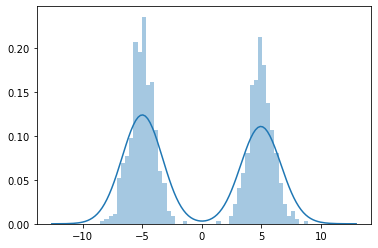

In [15]:
sns.distplot(all_proposals, bins=50)

In [16]:
a = t.randn(3,3)
b = t.randn(3,3)
a>b

tensor([[ True,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [17]:
x= t.tensor(0.)
x.item()

0.0

In [18]:
list(x.size()) == []

True

maybe we can build a twisted forward kernel now?


can we play around with this a bit and see if it does what we want it to do?
as a first sanity check, we can make sure that if the twisting is off, (i.e. uncontrolled), then there should be no 
twisting of a potential...right?


if we define a potential, we can make a kernel density plot for uncontrolled smc, right?

In [43]:
def uncontrolled_kernel_density(potential, parameter, x, y, dt):
    """
    report the log probability of transition from x to y under an Euler Maruyama discretized Unadjusted Langevin Algorithm
    """
    mu, sigma = EL_mu_sigma(x, 
                            potential(x, parameter),
                           dt)
    mvg = MultivariateNormal(mu, sigma)
    return mvg.log_prob(y)

In [114]:
positionsx = [t.tensor([[i]], requires_grad=True) for i in np.linspace(-1,1,30)]
positionsy = [t.tensor([[i]], requires_grad=True) for i in np.linspace(-1,1,30)]


_data = np.zeros((30, 30))
for idx, x in enumerate(positionsx):
    for idy, y in enumerate(positionsy):
        z = t.exp(uncontrolled_kernel_density(potential, 0., x, y, 1e-2)).detach()
        _data[idx, idy]=z
_data = np.array(_data)

No handles with labels found to put in legend.


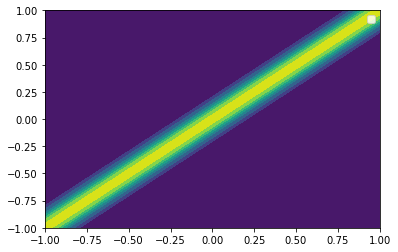

In [39]:
plt.contourf( np.linspace(-1,1,30),  np.linspace(-1,1,30), _data)
plt.legend()

In [117]:
def A(x, time):
    return t.eye(1)*0.
def b(x, time):
    return t.tensor([0.])
def c(x, time):
    return t.tensor(0.)
twisted_forward_kernel(x = t.tensor([0.], requires_grad=True), 
                       potential = potential, 
                       potential_parameters = t.tensor(0.), 
                       dt = 1e-2, 
                       A = A, 
                       A_parameters = 0., 
                       b = b, 
                       b_parameters = 0., 
                       c = c, 
                       c_parameters = 0., 
                       d_t = t.tensor([0.]))

1
f_t: tensor([0.])
A_t: tensor([[0.]])
b_t: tensor([0.])
c_t: 0.0
Theta: tensor([[1.]])
twisted_mean: tensor([0.])
twisted_sigma: tensor([[0.0100]])
square mahalanobis: 0.0
f_t.dot: 0.0
lognorm component 1, 2, 3 : (tensor(0.5000), tensor(0.), tensor([-0.]))


(tensor([-0.0967]), tensor([0.5000]))

In [106]:
Theta = t.tensor([[1.]])
t.log((Theta.det().sqrt()) * t.exp(0.5 / t.tensor(1e-2)) * t.exp(-0.5 / t.tensor(1e-2) ))

tensor(0.)

In [95]:
twisted_gmm_proposal(uncontrolled_alphas = t.tensor([0.1, 0.2, 0.7]),
                         uncontrolled_mus = t.tensor([[0.], [1.], [2.]]),
                         uncontrolled_Sigmas = t.stack([t.eye(1), t.eye(1), t.eye(1)]),
                         A_0 = t.zeros(1,1),
                         b_0 = t.zeros(1),
                         c_0 = t.tensor(0.))

(tensor([2.4076]), tensor(0.))

ok, so it would seem at this point that we have an algorithm with components that are functioninig properly. CSMC says that the twisted weights look like:
$$
w_0^{\psi^{(i)}} \equiv \frac{\pi_0(\psi_0^{(i)})}{\psi_0^{(i)}(x_0)}
$$
and 
$$
w_t^{\psi^{(i)}} \equiv \frac{w_t(x_{t-1}, x_t) K_t(\psi_t^{(i)})(x_{t-1})} {\psi_t^{(i)}(x_{t-1}, x_t)}
$$

In [343]:
def TwistedSMCSampler(potential,
                      uncontrolled_alphas,
                      uncontrolled_mus, 
                      uncontrolled_sigmas,
                      A0, 
                      b0,
                      c0,
                      A_t,
                      b_t,
                      c_t,
                      potential_parameter_sequence,
                      A_t_parameter_sequence,
                      b_t_parameter_sequence,
                      c_t_parameter_sequence,
                      dt,
                      uncontrolled=False):
    """
    given a potential, A0, b0, c0, as well as functions A_t, b_t, c_t (coupled with a sequence of appropriate parameters), conduct a
    forward pass of twisted SMC. 
    
    """
    #first thing to do is to make sure that the first dimension of all the sequences are the same length
    sequence_first_dimensions = [entry.size()[0] for entry in [A_t_parameter_sequence, b_t_parameter_sequence, c_t_parameter_sequence]]
    print(sequence_first_dimensions)
    sequence_length = sequence_first_dimensions[0]
    assert all(i ==sequence_first_dimensions[0] for i in sequence_first_dimensions)
    
    #make an object that will store the trajectory and the twisted works...
    trajectory = []
    twisted_log_weights = []
    
    #the potential parameter sequence is 1 greater than the rest since there is a parameterized _prior_ potential (index 0)
    assert sequence_first_dimensions[0] + 1 == potential_parameter_sequence.size()[0]
    
    #now we can conduct the pass of the 0th potential with a gaussian mixture model
    x, log_pi0_psi0 = twisted_gmm_proposal(uncontrolled_alphas,
                                           uncontrolled_mus,
                                           uncontrolled_sigmas,
                                           A0, b0, c0)
    trajectory.append(x.numpy())
    x.requires_grad=True #so we can compute potential gradient
    
    #compute log_twisted_w0
    log_phi0_x0 = quad_phi_0(x.detach(),A0.detach(), b0.detach(), c0.detach())
    if uncontrolled:
        assert np.isclose(log_phi0_x0, 0.)
        assert np.isclose(log_pi0_psi0, 0.)
    #print(log_psi0_x0)
    #print(log_pi0_psi0)
    initial_log_weight = log_pi0_psi0 + log_phi0_x0
    #print(initial_log_weight)
    twisted_log_weights.append(initial_log_weight)
                              
    #print(twisted_log_weights)
    
    #now we can iteration from t=1 to T
    for iteration in range(sequence_length):
        """
        we have to make a proposal and then compute the twisted weight;
        the twisted weight is the uncontrolled weight * K(\psi)(x_{t-1}) / \psi(x_{t-1}, x_t), 
        so we have to compute an uncontrolled weight first
        """
        old_potential_parameters = potential_parameter_sequence[iteration] #previous (is current by indexing)
        new_potential_parameters = potential_parameter_sequence[iteration+1] #current (is current+1 by indexing)
          
        #make a proposal
        d_t = t.tensor(0.)
#         print(b_t)
#         print(b_t_parameter_sequence[iteration])
        x_new, logK_psi = twisted_forward_kernel(x = x,
                                                 potential = potential,
                                                 potential_parameters = new_potential_parameters,
                                                 dt = dt,
                                                 A = A_t,
                                                 A_parameters=A_t_parameter_sequence[iteration],
                                                 b = b_t,
                                                 b_parameters=b_t_parameter_sequence[iteration],
                                                 c = c_t,
                                                 c_parameters=c_t_parameter_sequence[iteration],
                                                 d_t = d_t
                                                 )
        #print(f"logK_psi: {logK_psi}")
        assert not x_new.requires_grad
        x_new.requires_grad=True
        log_gamma_old = -potential(x.detach(), old_potential_parameters) # \log \gamma_{t-1}(x_{t-1})
        log_gamma_new = -potential(x_new, new_potential_parameters) # \log \gamma_{t}(x_t)
        x_auxiliary = x.clone().detach().requires_grad_(True) # get a gradable detached clone of the auxiliary x variable
        log_gamma_new_oldx = -potential(x_auxiliary, new_potential_parameters) # \log \gamma_{t}(x_{t-1})
        
        log_gamma_new.backward()
        log_gamma_new_oldx.backward()
        
        grad_log_gamma_x_old = x_auxiliary.grad
        grad_log_gamma_x_new = x_new.grad
        uncontrolled_log_weight = compute_ULA_logw(log_gamma_old = log_gamma_old,
                                                  log_gamma_new = log_gamma_new,
                                                  x_old = x_auxiliary,
                                                  x_new = x_new,
                                                  grad_log_gamma_x_new = grad_log_gamma_x_new,
                                                  grad_log_gamma_x_old = grad_log_gamma_x_old,
                                                  dt=dt)
        
        if uncontrolled:
            """
            we are going to make a uncontrolled smc proposal and validate that the log weight is the same as the `uncontrolled
            log weight`
            """
            uncontrolled_log_weight_check = log_gamma_new - log_gamma_old
            
            #forward
            x_old_validate = x_auxiliary.clone().detach().requires_grad_(True)
            #print(x_old_validate)
            mu_forward, sigma_forward = EL_mu_sigma(x_old_validate, potential(x_old_validate, new_potential_parameters), dt)
            forward_MVN = MultivariateNormal(mu_forward, sigma_forward)
            logp_forward = forward_MVN.log_prob(x_new.detach())
            
            #backward
            x_new_validate = x_new.clone().detach().requires_grad_(True)
            mu_backward, sigma_backward =  EL_mu_sigma(x_new_validate, potential(x_new_validate, new_potential_parameters), dt)
            backward_MVN = MultivariateNormal(mu_backward, sigma_backward)
            logp_backward = backward_MVN.log_prob(x_old_validate.detach())
            
            uncontrolled_log_weight_check += (logp_backward - logp_forward)
            
            assert np.isclose(uncontrolled_log_weight_check.item(), uncontrolled_log_weight.item(), atol=1e-3), f"check: {uncontrolled_log_weight_check.item()}, computed: {uncontrolled_log_weight.item()} "
            
        
        
        #print(old_potential_parameters)
        #print(new_potential_parameters)
        
        #compute phi_i
        phi_i = (square_mahalanobis_distance(x_new.detach(), A_t(x.detach(), A_t_parameter_sequence[iteration]))
                                 +x_new.detach().dot(b_t(x.detach(), b_t_parameter_sequence[iteration]))
                                 + c_t(c_t_parameter_sequence[iteration])
                                 + d_t
                )
        phi_t = quad_phi_t(x_tm1 = x.detach(), 
                           x_t = x_new.detach(), 
                           A_t = A_t, 
                           b_t = b_t, 
                           c_t = c_t, 
                           d_t = d_t, 
                           A_parameters = A_t_parameter_sequence[iteration], 
                           b_parameters = b_t_parameter_sequence[iteration], 
                           c_parameters = c_t_parameter_sequence[iteration]
                          )
        
#         print(f"phi_i: {phi_i}")
#         print(f"logK_psi: {logK_psi}")
#         print(f"uncontrolled_log_weight: {uncontrolled_log_weight}")
        twisted_log_weight = (uncontrolled_log_weight 
                              + logK_psi 
                              + phi_i
                             )
        if uncontrolled:
            assert np.isclose(logK_psi + phi_i, 0.)
        
        twisted_log_weights.append(twisted_log_weight) #log the twisted log weights
        trajectory.append(x_new.detach().numpy()) #log the new positions
        x = x_new.clone().detach().requires_grad_(True) #reinitialize the new position
    
    return trajectory, twisted_log_weights 

In [344]:
def dummy_A_t(x, param):
    return t.tensor([[0.]])
def dummy_b_t(x, param):
    return param[0]*(x-param[1])
    
def dummy_c_t(param):
    return t.tensor(0.)

In [452]:
import tqdm
#given the potential above, we are just shifting a gaussian...

iterations=100
sequence_length=20
trajs = []
twisted_log_weights = []
for iteration in tqdm.trange(iterations):
    traj, twisted_log_weight = TwistedSMCSampler(potential = potential,
                          uncontrolled_alphas = t.tensor([1.]),
                          uncontrolled_mus = t.tensor([[0.]]), 
                          uncontrolled_sigmas = t.tensor([[[0.5]]]), #this is the variance corresponding to the prior annealing protocol
                          A0 = t.tensor([[0.]]), #controlled gmm parameters are 0
                          b0 = t.tensor([0.]), #controlled gmm parameters are 0
                          c0 = t.tensor(0.), #controlled gmm parameters are 0
                          A_t = dummy_A_t,
                          b_t = dummy_b_t,
                          c_t = dummy_c_t,
                          potential_parameter_sequence = t.tensor(np.linspace(0,1,sequence_length)),
                          A_t_parameter_sequence = t.tensor([0. for _ in range(sequence_length-1)]), #this will always return 0
                          b_t_parameter_sequence = t.tensor([[0., 0.] for _ in range(sequence_length-1)]),
                          c_t_parameter_sequence = t.tensor(np.linspace(0,1,sequence_length)[1:]),
                          dt = 1e-2,
                          uncontrolled=True)
    trajs.append(traj)
    twisted_log_weights.append(twisted_log_weight)






  0%|          | 0/100 [00:00<?, ?it/s]

[19, 19, 19]







  1%|          | 1/100 [00:00<01:10,  1.40it/s]

[19, 19, 19]







  2%|▏         | 2/100 [00:01<01:13,  1.34it/s]

[19, 19, 19]







  3%|▎         | 3/100 [00:02<01:10,  1.38it/s]

[19, 19, 19]







  4%|▍         | 4/100 [00:02<01:10,  1.35it/s]

[19, 19, 19]







  5%|▌         | 5/100 [00:03<01:08,  1.39it/s]

[19, 19, 19]







  6%|▌         | 6/100 [00:04<01:05,  1.43it/s]

[19, 19, 19]







  7%|▋         | 7/100 [00:05<01:08,  1.36it/s]

[19, 19, 19]







  8%|▊         | 8/100 [00:05<01:07,  1.37it/s]

[19, 19, 19]







  9%|▉         | 9/100 [00:06<01:04,  1.41it/s]

[19, 19, 19]







 10%|█         | 10/100 [00:07<01:06,  1.36it/s]

[19, 19, 19]







 11%|█         | 11/100 [00:08<01:07,  1.33it/s]

[19, 19, 19]







 12%|█▏        | 12/100 [00:08<01:06,  1.33it/s]

[19, 19, 19]







 13%|█▎        | 13/100 [00:09<01:07,  1.28it/s]

[19, 19, 19]







 14%|█▍        | 14/100 [00:10<01:10,  1.22it/s]

[19, 19, 19]







 15%|█▌        | 15/100 [00:11<01:11,  1.19it/s]

[19, 19, 19]







 16%|█▌        | 16/100 [00:12<01:11,  1.18it/s]

[19, 19, 19]







 17%|█▋        | 17/100 [00:13<01:18,  1.05it/s]

[19, 19, 19]







 18%|█▊        | 18/100 [00:14<01:19,  1.03it/s]

[19, 19, 19]







 19%|█▉        | 19/100 [00:15<01:16,  1.06it/s]

[19, 19, 19]







 20%|██        | 20/100 [00:16<01:13,  1.08it/s]

[19, 19, 19]







 21%|██        | 21/100 [00:17<01:17,  1.02it/s]

[19, 19, 19]







 22%|██▏       | 22/100 [00:18<01:17,  1.01it/s]

[19, 19, 19]







 23%|██▎       | 23/100 [00:19<01:14,  1.04it/s]

[19, 19, 19]







 24%|██▍       | 24/100 [00:20<01:12,  1.04it/s]

[19, 19, 19]







 25%|██▌       | 25/100 [00:21<01:11,  1.05it/s]

[19, 19, 19]







 26%|██▌       | 26/100 [00:22<01:09,  1.07it/s]

[19, 19, 19]







 27%|██▋       | 27/100 [00:23<01:07,  1.08it/s]

[19, 19, 19]







 28%|██▊       | 28/100 [00:23<01:04,  1.11it/s]

[19, 19, 19]







 29%|██▉       | 29/100 [00:24<01:03,  1.12it/s]

[19, 19, 19]







 30%|███       | 30/100 [00:25<01:01,  1.14it/s]

[19, 19, 19]







 31%|███       | 31/100 [00:26<01:01,  1.12it/s]

[19, 19, 19]







 32%|███▏      | 32/100 [00:27<01:00,  1.12it/s]

[19, 19, 19]







 33%|███▎      | 33/100 [00:28<00:59,  1.13it/s]

[19, 19, 19]







 34%|███▍      | 34/100 [00:29<00:57,  1.14it/s]

[19, 19, 19]







 35%|███▌      | 35/100 [00:29<00:56,  1.15it/s]

[19, 19, 19]







 36%|███▌      | 36/100 [00:30<00:56,  1.13it/s]

[19, 19, 19]







 37%|███▋      | 37/100 [00:31<00:55,  1.14it/s]

[19, 19, 19]







 38%|███▊      | 38/100 [00:32<00:54,  1.14it/s]

[19, 19, 19]







 39%|███▉      | 39/100 [00:33<00:53,  1.15it/s]

[19, 19, 19]







 40%|████      | 40/100 [00:34<00:51,  1.16it/s]

[19, 19, 19]







 41%|████      | 41/100 [00:35<00:51,  1.15it/s]

[19, 19, 19]







 42%|████▏     | 42/100 [00:36<00:53,  1.09it/s]

[19, 19, 19]







 43%|████▎     | 43/100 [00:37<00:57,  1.00s/it]

[19, 19, 19]







 44%|████▍     | 44/100 [00:38<00:56,  1.02s/it]

[19, 19, 19]







 45%|████▌     | 45/100 [00:39<00:56,  1.02s/it]

[19, 19, 19]







 46%|████▌     | 46/100 [00:40<00:56,  1.04s/it]

[19, 19, 19]







 47%|████▋     | 47/100 [00:41<00:53,  1.02s/it]

[19, 19, 19]







 48%|████▊     | 48/100 [00:42<00:50,  1.02it/s]

[19, 19, 19]







 49%|████▉     | 49/100 [00:43<00:51,  1.01s/it]

[19, 19, 19]







 50%|█████     | 50/100 [00:44<00:49,  1.00it/s]

[19, 19, 19]







 51%|█████     | 51/100 [00:45<00:47,  1.03it/s]

[19, 19, 19]







 52%|█████▏    | 52/100 [00:46<00:45,  1.06it/s]

[19, 19, 19]







 53%|█████▎    | 53/100 [00:47<00:43,  1.09it/s]

[19, 19, 19]







 54%|█████▍    | 54/100 [00:48<00:41,  1.11it/s]

[19, 19, 19]







 55%|█████▌    | 55/100 [00:48<00:40,  1.12it/s]

[19, 19, 19]







 56%|█████▌    | 56/100 [00:49<00:39,  1.12it/s]

[19, 19, 19]







 57%|█████▋    | 57/100 [00:50<00:38,  1.13it/s]

[19, 19, 19]







 58%|█████▊    | 58/100 [00:51<00:37,  1.13it/s]

[19, 19, 19]







 59%|█████▉    | 59/100 [00:52<00:36,  1.13it/s]

[19, 19, 19]







 60%|██████    | 60/100 [00:53<00:35,  1.13it/s]

[19, 19, 19]







 61%|██████    | 61/100 [00:54<00:38,  1.02it/s]

[19, 19, 19]







 62%|██████▏   | 62/100 [00:55<00:38,  1.01s/it]

[19, 19, 19]







 63%|██████▎   | 63/100 [00:56<00:40,  1.10s/it]

[19, 19, 19]







 64%|██████▍   | 64/100 [00:57<00:38,  1.07s/it]

[19, 19, 19]







 65%|██████▌   | 65/100 [00:58<00:35,  1.02s/it]

[19, 19, 19]







 66%|██████▌   | 66/100 [00:59<00:33,  1.01it/s]

[19, 19, 19]







 67%|██████▋   | 67/100 [01:00<00:31,  1.05it/s]

[19, 19, 19]







 68%|██████▊   | 68/100 [01:01<00:29,  1.08it/s]

[19, 19, 19]







 69%|██████▉   | 69/100 [01:02<00:28,  1.10it/s]

[19, 19, 19]







 70%|███████   | 70/100 [01:03<00:27,  1.11it/s]

[19, 19, 19]







 71%|███████   | 71/100 [01:04<00:25,  1.12it/s]

[19, 19, 19]







 72%|███████▏  | 72/100 [01:04<00:24,  1.13it/s]

[19, 19, 19]







 73%|███████▎  | 73/100 [01:05<00:23,  1.14it/s]

[19, 19, 19]







 74%|███████▍  | 74/100 [01:06<00:22,  1.14it/s]

[19, 19, 19]







 75%|███████▌  | 75/100 [01:07<00:21,  1.15it/s]

[19, 19, 19]







 76%|███████▌  | 76/100 [01:08<00:21,  1.14it/s]

[19, 19, 19]







 77%|███████▋  | 77/100 [01:09<00:20,  1.15it/s]

[19, 19, 19]







 78%|███████▊  | 78/100 [01:10<00:19,  1.15it/s]

[19, 19, 19]







 79%|███████▉  | 79/100 [01:11<00:18,  1.15it/s]

[19, 19, 19]







 80%|████████  | 80/100 [01:11<00:17,  1.15it/s]

[19, 19, 19]







 81%|████████  | 81/100 [01:12<00:16,  1.15it/s]

[19, 19, 19]







 82%|████████▏ | 82/100 [01:13<00:15,  1.15it/s]

[19, 19, 19]







 83%|████████▎ | 83/100 [01:14<00:14,  1.15it/s]

[19, 19, 19]







 84%|████████▍ | 84/100 [01:15<00:13,  1.15it/s]

[19, 19, 19]







 85%|████████▌ | 85/100 [01:16<00:12,  1.16it/s]

[19, 19, 19]







 86%|████████▌ | 86/100 [01:17<00:12,  1.15it/s]

[19, 19, 19]







 87%|████████▋ | 87/100 [01:18<00:11,  1.15it/s]

[19, 19, 19]







 88%|████████▊ | 88/100 [01:18<00:10,  1.15it/s]

[19, 19, 19]







 89%|████████▉ | 89/100 [01:19<00:09,  1.15it/s]

[19, 19, 19]







 90%|█████████ | 90/100 [01:20<00:08,  1.15it/s]

[19, 19, 19]







 91%|█████████ | 91/100 [01:21<00:07,  1.14it/s]

[19, 19, 19]







 92%|█████████▏| 92/100 [01:22<00:07,  1.13it/s]

[19, 19, 19]







 93%|█████████▎| 93/100 [01:23<00:06,  1.13it/s]

[19, 19, 19]







 94%|█████████▍| 94/100 [01:24<00:05,  1.13it/s]

[19, 19, 19]







 95%|█████████▌| 95/100 [01:25<00:04,  1.13it/s]

[19, 19, 19]







 96%|█████████▌| 96/100 [01:25<00:03,  1.14it/s]

[19, 19, 19]







 97%|█████████▋| 97/100 [01:26<00:02,  1.13it/s]

[19, 19, 19]







 98%|█████████▊| 98/100 [01:27<00:01,  1.12it/s]

[19, 19, 19]







 99%|█████████▉| 99/100 [01:28<00:00,  1.14it/s]

[19, 19, 19]







100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


In [453]:
init_posits = [i[0] for i in trajs]
final_posits = [i[-1] for i in trajs]

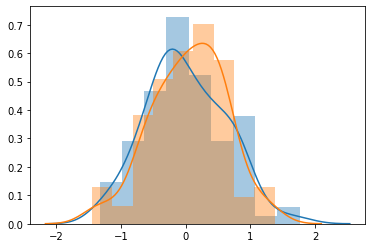

In [454]:
sns.distplot(init_posits)
sns.distplot(final_posits)

In [455]:
twisted_log_weights = np.array(twisted_log_weights)

In [456]:
cumulatie_log_weights = np.array([np.cumsum(entry) for entry in twisted_log_weights])
final_log_weights = [entry[-1] for entry in cumulatie_log_weights]

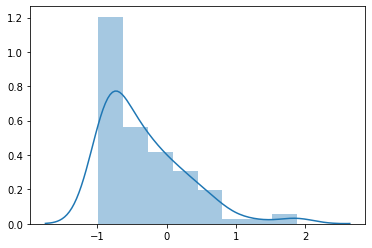

In [457]:
sns.distplot(final_log_weights)

In [458]:
free_energy = EXP(-np.array(final_log_weights))

In [459]:
free_energy

(0.09083455366387305, 0.10360092285358552)

In [460]:
np.exp(-free_energy[0])

0.9131687788308264

can we compare this to an ULA uncontrolled SMC?

In [354]:
# trajs = []
# logws = []
# sequence_length=5
# iterations=1000
# for iteration in tqdm.trange(iterations):
#     mvg = MultivariateNormal(t.tensor([[0.]]), t.tensor([[0.5]]))
#     x = mvg.sample()
#     x.requires_grad=True
#     traj, logw = full_ULA_uncontrolled_SMC_sequence(x, potential, t.tensor(np.linspace(0,1,sequence_length)), dt=1e-3)
#     #print(f"blaws: ", traj, logw)
#     trajs.append(traj)
#     logws.append(logw)

In [125]:
np_logws = np.array(logws)
cum_logws = np.array([np.cumsum(entry) for entry in np_logws])
sns.distplot([entry[-1] for entry in cum_logws])

NameError: name 'logws' is not defined

In [461]:
def ADP_value_training(x_sequences, 
                       twisted_log_weights, 
                       potential,
                       twisting_functions, 
                       twisting_parameters, 
                       minimization_iterations, 
                       epsilon, 
                       dt):
    """
    given a set of twisting functions \psi \in \Psi(Q), and a set of i.i.d. samples {X_{0:T}^n}_{n-1}^N from Q^{\psi},
    conduct approximate dynamic programming (ADP) for learning optimal sequences of potentials
    
    arguments
        x_sequences : t.tensor(R, T+1, M)
            trajectory sequence where R is the number of samples, T is the number of annealing steps, and M is the 
            dimension of x
        twisted_log_weights : t.tensor(R, T+1)
            log incremental weights of the R annealing samples
        twisting_functions : dict
            dictionary of functions corresponding to A, b, c
        twisting_initializers : dict
            dictionary of A0, b0, c0
        twisting_parameters : dict
            dictionary of gradable parameters 
            contains:
                A_t, b_t, c_t
        minimization_iterations : int
            number of iteration in minimization
        epsilon : float
            learning rate
        dt : t.tensor(float)
            timestep
    """
    #initialize by setting K_{T+1}^{\psi}(\exp{-V_{T+1}})(X_T^n) = 1 for n = 1, ..., N
    """
    iterate recursively from t=T, T-1, ..., 1
        a. define V_{comp, t} = -log(w_t^{\psi})(X_{t-1}, X_t) - log(K_{t+1}^{\psi})
    """
    num_samples, sequence_length = twisted_log_weights.size()[:2]
    print(f"num_samples, sequence length: {num_samples, sequence_length}")
    log_twisted_K = t.zeros(num_samples) #first log twisted Ks are 0.
    print(f"the twisting parameters are: {twisting_parameters}")
    
    #make holding variables for modified parameters:
    returnable_twisting_parameters = {key: [] for key, val in twisting_parameters.items()}
    
    #make a logger for the loss function 
    loss_functions = {}
    
    for time in tqdm.tqdm(range(sequence_length)[::-1]): #iterate backward from T to 1
        loss_logger = []
        print(f"time: {time}")
        #perform adp
        A_params = twisting_parameters['A_t'][time]
        b_params = twisting_parameters['b_t'][time]
        c_params = twisting_parameters['c_t'][time]
        #d_params = twisting_parameters['d_t'][t]
        
        for iteration in range(minimization_iterations):
            V_t_bar = -twisted_log_weights[:,time] - log_twisted_K # a.
            if time==0: #then we do not compute quad_phi_t, but rather the 0th iteration equivalent
                xis = [quad_phi_0(x_sequences[sample_idx, time], 
                                  A_params,
                                  b_params,
                                  c_params) for sample_idx in range(num_samples)
                      ]
            else:
                xis = [quad_phi_t(x_tm1 = x_sequences[sample_idx, time-1], 
                                       x_t = x_sequences[sample_idx, time], 
                                       A_t = twisting_functions['A_t'], 
                                       b_t = twisting_functions['b_t'], 
                                       c_t = twisting_functions['c_t'], 
                                       d_t = twisting_functions['d_t'], 
                                       A_parameters = A_params, 
                                       b_parameters = b_params, 
                                       c_parameters = c_params) for sample_idx in range(num_samples)
                            ]
            loss_function = sum([(i-j)**2 for i, j in zip(xis, V_t_bar)])
            loss_function.backward()
            loss_logger.append(loss_function.item())
#             print(f"loss: {loss_function.item()}")
#             print(f"b params: {b_params}")
            with t.no_grad():
                try:
                    A_params -= epsilon * A_params.grad
                    A_params.grad.zero_()
                except Exception as e:
                    #print(f"A_param optimizer: {e}")
                    pass
                try:
                    b_params -= epsilon * b_params.grad
                    b_params.grad.zero_()
                except Exception as e:
                    #print(f"b_params optimizer: {e}")
                    pass
                try:
                    c_params -= epsilon * c_params.grad
                    c_params.grad.zero_()
                except Exception as e:
                    #print(f"c_params optimizer: {e}")
                    pass
#                 try:
#                     d_params -= epsilon * d_params.grad
#                 except Exception as e:
#                     print(f"d_params optimizer: {e}")
        #recompute the log_twisted_K
        if time > 0:
            log_twisted_K = t.tensor(
                                    [twisted_forward_kernel(x = _x.clone().detach().requires_grad_(True),
                                     potential = potential, 
                                     potential_parameters=twisting_parameters['potential'][time],
                                     dt = dt,
                                     A = twisting_functions['A_t'],
                                     A_parameters = A_params.detach(),
                                     b = twisting_functions['b_t'],
                                     b_parameters = b_params.detach(),
                                     c = twisting_functions['c_t'],
                                     c_parameters = c_params.detach(),
                                     d_t = t.tensor(0.))[1] for _x in x_sequences[:, time-1]
                                    ]
                                    )
        #for each of the parameters, update the returnable_twisting_parameters_dict...
        for key, param in zip(['A_t', 'b_t', 'c_t'], [A_params, b_params, c_params]):
            returnable_twisting_parameters[key].append(param.detach())
        
        #add the loss logger to the loss dictionary
        loss_functions[time] = np.array(loss_logger)
    
    
    print(f"returnable twisting parameters: {returnable_twisting_parameters}")
    flipped_returnable_twisting_parameters = {key: lst[::-1] for key, lst in returnable_twisting_parameters.items()}
    return flipped_returnable_twisting_parameters, loss_functions
      

In [462]:
twisting_parameters, loss_functions = ADP_value_training(x_sequences = t.tensor(np.array(trajs)), 
                       twisted_log_weights = t.tensor(twisted_log_weights), 
                       potential = potential,
                       twisting_functions = {'A_t': dummy_A_t, 'b_t': dummy_b_t, 'c_t': dummy_c_t, 'd_t': t.tensor(0.)}, 
                       twisting_parameters = {'A_t': [t.tensor([[0.]]) for _ in range(sequence_length)],
                                              'b_t': [t.tensor([0.], requires_grad=True)] +  [t.tensor([0., 0.], requires_grad=True) for _  in range(sequence_length-1)],
                                              'c_t': [t.tensor(0.) for _ in range(sequence_length)],
                                              'potential': t.tensor(np.linspace(0,1,sequence_length))}, 
                       minimization_iterations=20, 
                       epsilon = 1e-3, 
                       dt = 1e-2)






  0%|          | 0/20 [00:00<?, ?it/s]

num_samples, sequence length: (100, 20)
the twisting parameters are: {'A_t': [tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]])], 'b_t': [tensor([0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_grad=True), tensor([0., 0.], requires_g






  5%|▌         | 1/20 [00:12<03:48, 12.00s/it]

time: 18







 10%|█         | 2/20 [00:28<03:58, 13.27s/it]

time: 17







 15%|█▌        | 3/20 [00:42<03:52, 13.70s/it]

time: 16







 20%|██        | 4/20 [00:57<03:43, 13.99s/it]

time: 15







 25%|██▌       | 5/20 [01:13<03:36, 14.42s/it]

time: 14







 30%|███       | 6/20 [01:28<03:24, 14.64s/it]

time: 13







 35%|███▌      | 7/20 [01:42<03:10, 14.66s/it]

time: 12







 40%|████      | 8/20 [02:00<03:04, 15.42s/it]

time: 11







 45%|████▌     | 9/20 [02:15<02:50, 15.46s/it]

time: 10







 50%|█████     | 10/20 [02:33<02:41, 16.19s/it]

time: 9







 55%|█████▌    | 11/20 [02:48<02:21, 15.71s/it]

time: 8







 60%|██████    | 12/20 [03:04<02:08, 16.05s/it]

time: 7







 65%|██████▌   | 13/20 [03:18<01:47, 15.35s/it]

time: 6







 70%|███████   | 14/20 [03:32<01:29, 14.88s/it]

time: 5







 75%|███████▌  | 15/20 [03:46<01:12, 14.54s/it]

time: 4







 80%|████████  | 16/20 [03:59<00:57, 14.27s/it]

time: 3







 85%|████████▌ | 17/20 [04:13<00:42, 14.08s/it]

time: 2







 90%|█████████ | 18/20 [04:27<00:27, 13.98s/it]

time: 1







 95%|█████████▌| 19/20 [04:41<00:13, 13.93s/it]

time: 0







100%|██████████| 20/20 [04:48<00:00, 14.40s/it]

returnable twisting parameters: {'A_t': [tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]]), tensor([[0.]])], 'b_t': [tensor([2.6602e-03, 9.2643e-05]), tensor([0.0055, 0.0002]), tensor([0.0066, 0.0002]), tensor([0.0061, 0.0002]), tensor([0.0064, 0.0002]), tensor([0.0075, 0.0003]), tensor([0.0061, 0.0002]), tensor([0.0041, 0.0002]), tensor([0.0031, 0.0001]), tensor([0.0045, 0.0002]), tensor([0.0036, 0.0001]), tensor([-8.5714e-04, -3.5406e-05]), tensor([-0.0053, -0.0002]), tensor([-0.0088, -0.0004]), tensor([-0.0136, -0.0006]), tensor([-0.0155, -0.0007]), tensor([-0.0134, -0.0006]), tensor([-0.0133, -0.0006]), tensor([-0.0161, -0.0008]), tensor([-0.0016])], 'c_t': [tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tens

In [423]:
len(loss_functions)

200

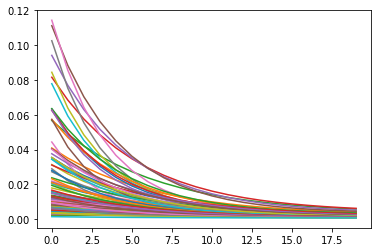

In [425]:
for i in range(100, 200):
    plt.plot(loss_functions[i])

In [426]:
twisting_parameters

{'A_t': [tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  tensor([[0.]]),
  t

In [398]:
t.stack(twisting_parameters['b_t'][1:]).squeeze(0).size()

torch.Size([49, 2])

In [399]:
sequence_length

50

In [142]:
t.tensor([0. for _ in range(sequence_length-1)])

tensor([0.])

In [442]:
import tqdm
#given the potential above, we are just shifting a gaussian...

iterations=50
sequence_length=200
trajs = []
twisted_log_weights = []
for iteration in tqdm.trange(iterations):
    traj, twisted_log_weight = TwistedSMCSampler(potential = potential,
                          uncontrolled_alphas = t.tensor([1.]),
                          uncontrolled_mus = t.tensor([[0.]]), 
                          uncontrolled_sigmas = t.tensor([[[0.5]]]), #this is the variance corresponding to the prior annealing protocol
                          A0 = t.tensor([[0.]]), #controlled gmm parameters are 0
                          b0 = twisting_parameters['b_t'][0], #controlled gmm parameters are 0
                          c0 = t.tensor(0.), #controlled gmm parameters are 0
                          A_t = dummy_A_t,
                          b_t = dummy_b_t,
                          c_t = dummy_c_t,
                          potential_parameter_sequence = t.tensor(np.linspace(0,1,sequence_length)),
                          A_t_parameter_sequence = t.tensor([0. for _ in range(sequence_length-1)]), #this will always return 0
                          c_t_parameter_sequence = t.tensor(np.linspace(0,1,sequence_length)[1:]),
                          b_t_parameter_sequence = t.stack(twisting_parameters['b_t'][1:]),
                          dt = 1e-2,
                          uncontrolled=False)
    trajs.append(traj)
    twisted_log_weights.append(twisted_log_weight)






  0%|          | 0/50 [00:00<?, ?it/s]

[199, 199, 199]







  2%|▏         | 1/50 [00:04<03:17,  4.03s/it]

[199, 199, 199]







  4%|▍         | 2/50 [00:08<03:24,  4.26s/it]

[199, 199, 199]







  6%|▌         | 3/50 [00:13<03:32,  4.51s/it]

[199, 199, 199]







  8%|▊         | 4/50 [00:19<03:46,  4.93s/it]

[199, 199, 199]







 10%|█         | 5/50 [00:25<03:54,  5.21s/it]

[199, 199, 199]







 12%|█▏        | 6/50 [00:32<04:05,  5.59s/it]

[199, 199, 199]







 14%|█▍        | 7/50 [00:38<04:03,  5.67s/it]

[199, 199, 199]







 16%|█▌        | 8/50 [00:43<03:55,  5.61s/it]

[199, 199, 199]







 18%|█▊        | 9/50 [00:48<03:45,  5.50s/it]

[199, 199, 199]







 20%|██        | 10/50 [00:54<03:38,  5.47s/it]

[199, 199, 199]







 22%|██▏       | 11/50 [01:00<03:40,  5.65s/it]

[199, 199, 199]







 24%|██▍       | 12/50 [01:06<03:40,  5.79s/it]

[199, 199, 199]







 26%|██▌       | 13/50 [01:13<03:44,  6.07s/it]

[199, 199, 199]







 28%|██▊       | 14/50 [01:19<03:43,  6.20s/it]

[199, 199, 199]







 30%|███       | 15/50 [01:25<03:32,  6.08s/it]

[199, 199, 199]







 32%|███▏      | 16/50 [01:31<03:23,  6.00s/it]

[199, 199, 199]







 34%|███▍      | 17/50 [01:36<03:08,  5.71s/it]

[199, 199, 199]







 36%|███▌      | 18/50 [01:41<03:01,  5.67s/it]

[199, 199, 199]







 38%|███▊      | 19/50 [01:48<03:06,  6.02s/it]

[199, 199, 199]







 40%|████      | 20/50 [01:55<03:05,  6.19s/it]

[199, 199, 199]







 42%|████▏     | 21/50 [02:01<02:58,  6.14s/it]

[199, 199, 199]







 44%|████▍     | 22/50 [02:07<02:53,  6.21s/it]

[199, 199, 199]







 46%|████▌     | 23/50 [02:13<02:44,  6.08s/it]

[199, 199, 199]







 48%|████▊     | 24/50 [02:19<02:40,  6.18s/it]

[199, 199, 199]







 50%|█████     | 25/50 [02:26<02:36,  6.24s/it]

[199, 199, 199]







 52%|█████▏    | 26/50 [02:31<02:23,  5.99s/it]

[199, 199, 199]







 54%|█████▍    | 27/50 [02:38<02:23,  6.23s/it]

[199, 199, 199]







 56%|█████▌    | 28/50 [02:44<02:15,  6.17s/it]

[199, 199, 199]







 58%|█████▊    | 29/50 [02:50<02:06,  6.04s/it]

[199, 199, 199]







 60%|██████    | 30/50 [02:55<01:56,  5.81s/it]

[199, 199, 199]







 62%|██████▏   | 31/50 [03:00<01:47,  5.65s/it]

[199, 199, 199]







 64%|██████▍   | 32/50 [03:05<01:39,  5.53s/it]

[199, 199, 199]







 66%|██████▌   | 33/50 [03:11<01:32,  5.44s/it]

[199, 199, 199]







 68%|██████▊   | 34/50 [03:16<01:26,  5.40s/it]

[199, 199, 199]







 70%|███████   | 35/50 [03:21<01:20,  5.36s/it]

[199, 199, 199]







 72%|███████▏  | 36/50 [03:26<01:14,  5.32s/it]

[199, 199, 199]







 74%|███████▍  | 37/50 [03:32<01:09,  5.31s/it]

[199, 199, 199]







 76%|███████▌  | 38/50 [03:37<01:03,  5.31s/it]

[199, 199, 199]







 78%|███████▊  | 39/50 [03:42<00:58,  5.30s/it]

[199, 199, 199]







 80%|████████  | 40/50 [03:48<00:53,  5.33s/it]

[199, 199, 199]







 82%|████████▏ | 41/50 [03:53<00:47,  5.33s/it]

[199, 199, 199]







 84%|████████▍ | 42/50 [03:58<00:42,  5.29s/it]

[199, 199, 199]







 86%|████████▌ | 43/50 [04:03<00:36,  5.28s/it]

[199, 199, 199]







 88%|████████▊ | 44/50 [04:09<00:31,  5.26s/it]

[199, 199, 199]







 90%|█████████ | 45/50 [04:14<00:26,  5.25s/it]

[199, 199, 199]







 92%|█████████▏| 46/50 [04:21<00:22,  5.67s/it]

[199, 199, 199]







 94%|█████████▍| 47/50 [04:26<00:16,  5.62s/it]

[199, 199, 199]







 96%|█████████▌| 48/50 [04:33<00:11,  5.92s/it]

[199, 199, 199]







 98%|█████████▊| 49/50 [04:39<00:06,  6.07s/it]

[199, 199, 199]







100%|██████████| 50/50 [04:45<00:00,  5.71s/it]


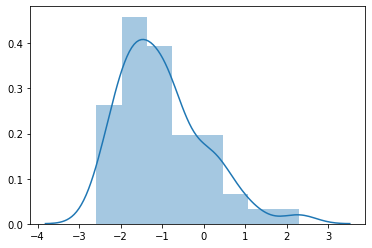

In [443]:
twisted_log_weights = np.array(twisted_log_weights)
cumulatie_log_weights = np.array([np.cumsum(entry) for entry in twisted_log_weights])
log_weights = np.array([entry[-1] for entry in cumulatie_log_weights])
sns.distplot(log_weights)

In [444]:
-np.log(np.sqrt(2))

-0.3465735902799727

In [445]:
from pymbar import EXP

In [446]:
free_energy = EXP(-log_weights)

In [447]:
free_energy

(0.33139222616178854, 0.28437118652469745)

In [448]:
np.exp(-free_energy[0])

0.7179235254213494

In [331]:
initial_posts = [tra[0] for tra in trajs]
final_posts = [tra[-1] for tra in trajs]

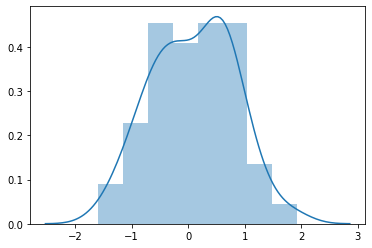

In [332]:
sns.distplot(initial_posts)


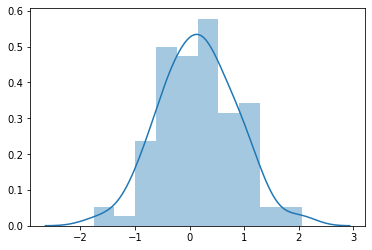

In [278]:
sns.distplot(final_posts)

perhaps we should like to rewrite everything in numpy and use pytorch _only_ for optimization

In [493]:
def log_probability(potential):
    """
    generate a log unnormalized probability
    
    arguments
        potential : np.float
            -log unnormalized probability density
    """
    return np.exp(-potential)

In [516]:
def EL_mu_sigma(x, func, dt, parameters, is_force_function=False,  **kwargs):
    """
    create mean vector and covariance marix for a multivariate gaussian proposal
    """
    tau = dt/2.
    if not is_force_function:
        #we have to compute a numerical approximation of the gradient
        force = compute_force(x, func, parameters, **kwargs)
    else: #it is a force function, in which case, we just plug in the x, potential_params
        force = func(x, parameters, **kwargs)
    
    #now we can compute mu and Sigma
    mu = x + tau * force
    Sigma = 2*tau * np.eye(len(x))
    
    return mu, Sigma

In [510]:
def compute_force(x, potential_function, potential_parameters, eps=None):
    """
    given a potential function, compute an approximation of the Force (i.e. -grad(potential_function(x, parameters)))
    """
    from scipy.optimize import approx_fprime

    if not eps:
        eps = np.sqrt(np.finfo(float).eps)
    epsilons = [eps]*len(x)
    grad_potential = approx_fprime(x, potential_function, epsilons, potential_parameters)
    return -grad_potential

In [511]:
def potential(x, potential_parameters):
    return np.sum(potential_parameters * x**2)

In [568]:
def compute_ULA_logw():
    """
    compute the unadjusted langevin algorithm log_weight
    """
    logw = (
            -potentialt_xt
            + 0.5 * x_tm1.dot(forcet_xt)
            - 0.5 * xt.dot(forcet_xt)
            - (dt/8.)*np.sum(forcet_xt**2)
            + potentialtm1_xtm1
            - 0.5 * x_t.dot(forcet_xtm1)
            + 0.5 * xtm1.dot(forcet_xtm1)
            + (dt/8.)*np.sum(forcet_xtm1**2)
            )
    return logw

def compute_generalized_logw(log_gamma_old, log_gamma_new, log_forward_kernelt, log_backward_kernel_tm1):
    """
    compute a generalized log incremental (unnormalized) weight
    """
    logw = log_gamma_new + log_backward_kernel_tm1 - log_gamma_old - log_forward_kernelt
    return logw

def twisted_gmm_components(uncontrolled_alphas, uncontrolled_mus, uncontrolled_Sigmas, A0, b0, c0):
    """
    compute a twisted gaussian mixture model mixing components, twisted_mu, and twisted_Sigma
    """
    assert len(uncontrolled_alphas) == len(uncontrolled_mus)
    components, dimensions = uncontrolled_mus.shape
    assert uncontrolled_Sigmas.shape == (components, dimension, dimension)
    
    #compute mixture components
    Sigma_tilde_js = np.linalg.inv(np.linalg.inv(uncontrolled_Sigmas) + 2.0*A0)
    log_zetas = np.array([
                            gmm_log_zetas(sigma_tilde_j, sigma_j, mu_j, b0, c0) 
                            for sigma_tilde_j, sigma_j in 
                            zip(Sigma_tilde_js, uncontrolled_Sigmas)
                            ])
    log_alpha_tildes = np.log(uncontrolled_alphas) + log_zetas
    
    return log_alpha_tildes, Sigma_tilde_js

def twisted_gmm_proposal(log_alpha_tildes, Sigma_tilde_js, b0):
    """
    make a twisted gaussian mixture model proposal
    """
    from scipy.special import logsumexp
    from scipy.stats import multivariate_normal
    normalized_alpha_tildes = np.exp(log_alpha_tildes - logsumexp(log_alpha_tildes))
    #choose a component
    component_index = np.random.choice(range(len(normalized_alpha_tildes)), p = normalized_alpha_tildes)
    
    #then choose a position based on that gaussian
    Sigma_tilde_j = Sigma_tilde_js[component_index]
    mu_j = uncontrolled_mus[component_index]
    Sigma_j = uncontrolled_Sigmas[component_index]
    twisted_mean = np.matmul(Sigma_tilde_j, np.matmul(np.linalg.inv(Sigma_j), mu_j) - b0)
    twisted_Sigma = Sigma_tilde_j
    x = multivariate_normal.rvs(mean=twisted_mean, cov = twisted_Sigma)
    logpdf = multivariate_normal.logpdf(x, mean=twisted_mean, cov = twisted_Sigma)
    return x, logpdf

def compute_twisted_gmm_lognormalizer(log_alpha_tildes):
    """
    compute the twisted gaussian mixture model log normalization constant with unnormalized log_alpha_tildes
    """
    from scipy.special import logsumexp
    return logsumexp(log_alpha_tildes)


In [570]:
def gmm_log_zetas(Sigma_tilde_j, Sigma_j, mu_j, b0, c0):
    """
    compute the logzeta_js mixture components
    """
    from scipy.spatial.distance import mahalanobis
    comp1 = -0.5 * np.log(np.linalg.det(Sigma_j))
    comp2 = 0.5 * np.log(np.linalg.det(Sigma_tilde_j))
    comp3 = 0.5 * mahalanobis(np.matmul(np.linalg.inv(Sigma_j), mu_j), b0, np.linalg.inv(Sigma_tilde_j))**2
    comp4 = -0.5 * mahalanobis(mu_j, np.zeros(len(mu_j)), Sigma_j)**2
    comp5 = -c0
    return comp1 + comp2 + comp3 + comp4 + comp5


In [ ]:
def Theta_t(x_tm1, A_t, dt):
    """
    compute Theta_t = (I_d _ 2*dt*A_t(x_tm1))^-1
    """
    theta = np.linalg.inv(np.eye(len(x_tm1)) + 2. * dt * A_t)
    return theta

def f_t(x_tm1, potential_function, parameters, dt, **kwargs):
    """
    NOTE : parameters should reflect potential function at time t (not t-1)
    compute f_t(x_tm1) = x_tm1 + 0.5 * dt * forcet(x_tm1) = mu
    """
    mu, cov = EL_mu_sigma(x_tm1, potential_function, dt, parameters, is_force_function=False,  **kwargs)
    return mu
    

def twisted_forward_tools(x, potential_function, potential_parameters, A_function, A_parameters, dt, **kwargs):
    """
    make a twisted forward 
    """
    dimension = len(x) #grab the dimension of x  
    f_t = f_t(x, potential_function, potential_parameters, dt)
    A_t = A_function(x, A_parameters)
    
    #theta and f
    theta = Theta_t(x, A_t, dt)
    f = f_t(x, potential, potential, dt) 
    
    return theta, f

def twisted_forward_proposal(theta, f, dt, b_t, **kwargs):
    """
    make a forward twisted proposal
    """
    twisted_mean = np.matmul(theta, f - dt*b_t)
    twisted_covariance = dt * theta
    x = multivariate_normal.rvs(mean=twisted_mean, cov = twisted_covariance)
    return x

def twisted_forward_log_normalizer(theta, f, b_t, dt, c, d):
    """
    perform one line computation to calculate the log normalization constant of the twisted forward proposal
    """
    from scipy.spatial.distance import mahalanobis
    
    #there are 3 components that will be computed separately and added.
    comp1 = 0.5 * np.linalg.det(theta)
    comp2 = (1./(2.*dt)) * mahalanobis(f, dt*b_t, np.linalg.inv(theta))**2
    comp3 = -(1./(2.*dt)) * f.dot(f) - c - d
    
    log_forward_normalizer = comp1 + comp2 + comp3
    return log_forward_normalizer


    

In [520]:
a = np.array([1, 2, 3, 4]).transpose()

In [518]:
b = np.array([0, 2, 3, 4])

In [522]:
a.dot(b)

29

In [524]:
a**2

array([ 1,  4,  9, 16])

In [533]:
a = np.array([[0., 1., 2.], [0., 1., 4.]]).shape

In [534]:
a

(2, 3)

In [550]:
q = np.random.rand(2, 2)

In [551]:
np.matmul(q, np.array([1, 2]))

array([1.28428833, 0.7307282 ])

In [546]:
A0 = np.random.rand(2,2)

In [549]:
np.linalg.inv(np.linalg.inv(q) - A0)

array([[[-1.576164  , -2.02098825],
        [-1.26933011, -1.63527357]],

       [[-1.77727294, -0.40937136],
        [-2.31573061, -0.91507988]],

       [[-5.44517426, -4.14130285],
        [-6.4488603 , -6.02384262]]])

In [548]:
np.array([np.linalg.inv(it) - A0 for it in q])

array([[[-134.50070268,  166.2256053 ],
        [ 104.40197526, -129.63895988]],

       [[  -1.34897318,    0.60347845],
        [   3.41375496,   -2.61998279]],

       [[  -0.98845677,    0.67954944],
        [   1.05819824,   -0.89350266]]])

In [560]:
from scipy.stats import multivariate_normal
mv = multivariate_normal.rvs(mean = np.array([0., 1.]), cov = np.eye(2))

In [566]:
%%time
mv = multivariate_normal.rvs(mean = np.random.randn(2000), cov = np.eye(2000))

CPU times: user 27 s, sys: 3.64 s, total: 30.7 s
Wall time: 4.19 s
